In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import pickle as pickle
from joblib import Parallel, delayed
import sys
from cr_simulation.CR import *

### For any clarifications, please check the docs of functions in the source code

# 2 Qubits

## Configuration

In [3]:
# Configure Processor
# Number of Qubits
N = 2 

# Number of Levels per qubit
N_l = 4

# Frequencies of qubits, in Grad/s
w = np.array([5.3*2*np.pi,5.23*2*np.pi])

# Anharmonicities of qubits in Grad/s
anh_array = 2*np.pi*1e-3*np.array([300,300])

# Coupling between qubits in Grad/s
g = 0.003*2*np.pi

# Connectivity of the processor
# J[i][j] = g means qubit 'i' and 'j' are coupled with strength g
J = [[0,g],
     [g,0]]

# Specification of which qubit is control and which is target
# control_target[i][j] = 1 means qubit 'i' is the control and qubit 'j' is the target, for that coupling
control_target = [[0,1],
                  [0,0]]

# Note: Other variables to enable progress bars/saving of propagators can be enabled.
# Look at the __init__ function of the processor class

In [4]:
# Define the main class object
pr = processor(N,N_l,w,anh_array,J,control_target)

In [5]:
# Use the cosine rise/fall function already written in the library
# If need be, you can define your own pulse function, and pass arguments using a dictionary, as shown below
pulse_function = pulse_coeff

# Configure Pulse Parameters
args = {}
# Max pulse amplitude in Grad/s
args['Emax'] = 1e-3*39*2*np.pi
# Pulse time in ns
args['tp'] = 140
# Fraction of total pulse time occupied by rise time
args['rf'] = 0.3
# Discretization of the pulse
args['t_step'] = 0.5

# List of time points
t_list = np.arange(0,args['tp'],args['t_step'])

### Processor diagnostics

Check the proximity to poles, see the spread of frequencies of each qubit due to ZZ shift

In [6]:
# Run processor diagnostics to check for proximity to poles
# See thesis page 14, 15, 16
# Set tolerance for proximity to poles, in this case 30 MHz
tol = 30*1e-3*2*np.pi
check_resonance(pr,tol)

# Prints a table of control target pairs
# And indicates which region of the frequency landscape their detuning lies
# See plots on thesis page 14
region_classifier(pr)

+----------+---+---+
| Ctrl\Tgt | 0 | 1 |
+----------+---+---+
| 0        | - | 2 |
+----------+---+---+
| 1        | - | - |
+----------+---+---+


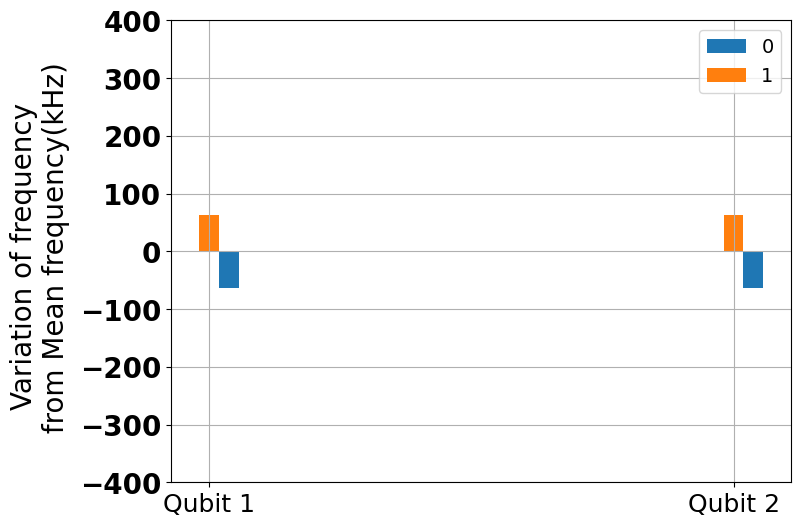

In [7]:
pr.plot_static_zz(option = 'Mean', legend = True)

## Single Qubit Gates

### Calibration

In [8]:
# Let's calibrate a π pulse

# Array of drive strengths in MHz
E_list_rx = np.linspace(1,25,25)

# Array of pulse times for initial testing in ns
t_list_rx = np.arange(10,15,1)


# Select qubit and set drive frequency
# We have chosen qubit 0
tgt = 0
# We set the drive frequency to the mean of the frequencies that the qubit takes due to ZZ shift
drive_frequency = pr.qubits[tgt]['w_mean_kerr']

In [9]:
# Calibrate
# Pass the above defined settings
# use_optimizer = True uses a numerical optimizer to extract rotation angles from the time propagator
ts,phi = pr.calibrate_X_t(np.pi,tgt,drive_frequency,pulse_function,args,E_list = E_list_rx, t_list = t_list_rx, use_optimizer = True)

# phi corresponds to the angles of rotation for each value of E_list for pulse times in t_list

100%|██████████| 25/25 [00:07<00:00,  3.14it/s]


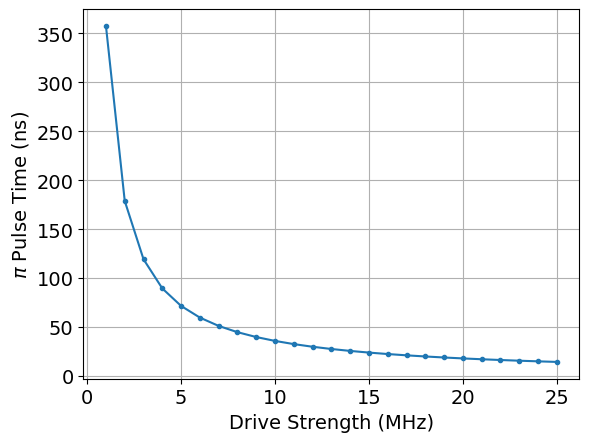

In [10]:
# Plot
plt.plot(E_list_rx,np.array(ts),'.-')       
plt.grid()
plt.xlabel("Drive Strength (MHz)")
plt.ylabel(r"$\pi$ Pulse Time (ns)")
plt.show()

In [ ]:
# Save the list of times for use in further simulations
# Since it doesn't depend on qubit frequency, we can use the same calibration for all qubits
pi_times_path = "./pickles/pi_pulse_times_example.pkl"

# Create a dictionary of dict[E_list[i]] = ts[i]
# This is the standard format for saving pulse times
tdict = dict(zip(E_list_rx, ts))

# Save
with open(pi_times_path,'wb') as f:
    pickle.dump(tdict,f)

### Error Budget

In [12]:
# Let us compute the error budget for each of these drive strengths (for the same qubit)
calib_path = pi_times_path # Need to pass calibration to function
# no_CP = True # Use this to also calculate conditional phase errors - this doesn't work perfectly always
E, E_T, E_specs, E_leak = pr.E_vs_F_new_error_budget_RX(tgt,drive_frequency, calib_path, pulse_function, args = args)

25it [00:01, 17.78it/s]


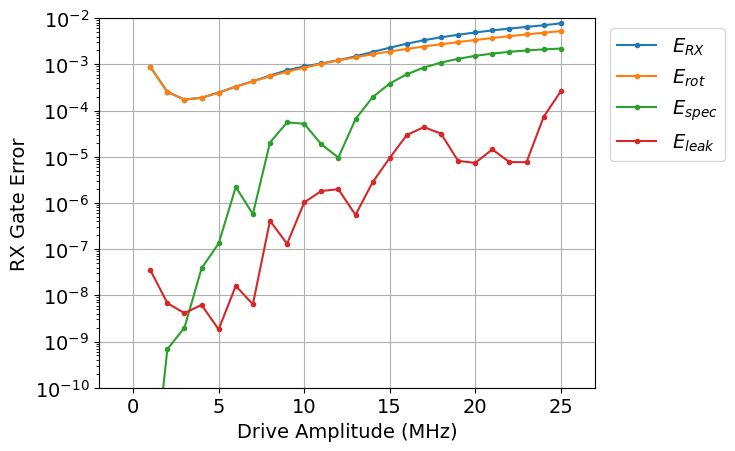

In [13]:
# Plot
plt.semilogy(E_list_rx,np.array(E), '.-', label = r'$E_{{RX}}$')
# plt.plot(E_list_rx,np.array(E_CP), '.-', label = r'$E_{{CP}}$')
plt.semilogy(E_list_rx,np.array(E_T), '.-', label = r'$E_{{rot}}$')
plt.semilogy(E_list_rx,np.array([i[0] for i in E_specs]), '.-', label = r'$E_{{spec}}$')
plt.semilogy(E_list_rx,np.array(E_leak), '.-', label = r'$E_{{leak}}$')

plt.grid()
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("RX Gate Error", fontsize = 14)
plt.ylim(1e-10,1e-2)
plt.xlim(-2,27)
plt.legend(bbox_to_anchor = (1.01,1.0), fontsize = 14)
plt.show()

## CR Gate

In [14]:
# Define the Control and Target
ctrl = 0
tgt = 1
# Use mean kerr frequency of target
drive_frequency = pr.qubits[tgt]['w_mean_kerr']

### Effective Hamiltonian

Works only for the two qubit case so far

In [15]:
# Detuning range in GHz
det_start = -0.15 
det_stop = 0.4505 
det_step = 0.002 

# Drive range in GHz
drive_start = 0 
drive_stop = 0.05005 
drive_step = 0.01 

dets = np.arange(det_start, det_stop, det_step)
drives = np.arange(drive_start, drive_stop, drive_step)


zx = np.zeros([drives.size, dets.size], dtype = float)
ix = np.zeros([drives.size, dets.size], dtype = float)
# zy = np.zeros([drives.size, dets.size], dtype = float)
# iy = np.zeros([drives.size, dets.size], dtype = float)
zz = np.zeros([drives.size, dets.size], dtype = float)
iz = np.zeros([drives.size, dets.size], dtype = float)
# figm = np.zeros([drives.size, dets.size], dtype = float)

# Extract coefficients
for k1 in tqdm(range(0, drives.size)):
    for j1 in range(0, dets.size):
        l = dets[j1]+4.6
        y = drives[k1]
        int_mhz = 1000*interactions(4, l, 4.6, -0.300, -0.3, 0.004, y, 0.00, 0, 0, 4.6)
        zx[k1, j1] =  int_mhz[0]
        ix[k1, j1] =  int_mhz[1]
        zz[k1, j1] =  int_mhz[4]
        iz[k1, j1] =  int_mhz[5]
#        figm[k1, j1] = fig_merit(4, l, 4.6, -0.300, -0.300, 0.004, y, 0.00, 0, 0, 4.6)


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


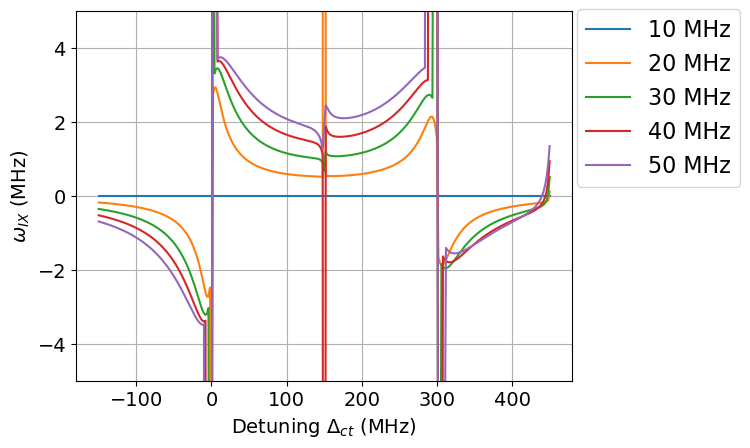

In [16]:
fig, ax = plt.subplots()
plt.plot(1000*dets, -zx[0],  '-', label = "10 MHz")
plt.plot(1000*dets, -zx[1],  '-', label = "20 MHz")
plt.plot(1000*dets, -zx[2],  '-', label = "30 MHz")
plt.plot(1000*dets, -zx[3],  '-', label = "40 MHz")
plt.plot(1000*dets, -zx[4],  '-', label = "50 MHz")

plt.ylim(-5,5)
plt.grid()
plt.legend(fontsize = 16, loc = (1.01,0.525))
plt.xlabel(r"Detuning $\Delta_{ct}$ (MHz)")
plt.ylabel(r"$\omega_{IX}$ (MHz)")

plt.show()


### Calibration

In [17]:
E_list = np.arange(3,90,3)
t_list = np.arange(50,150,25)
ts,phi0,phi1 = pr.calibrate_cnot_t(ctrl,tgt,drive_frequency,pulse_function,args)

100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


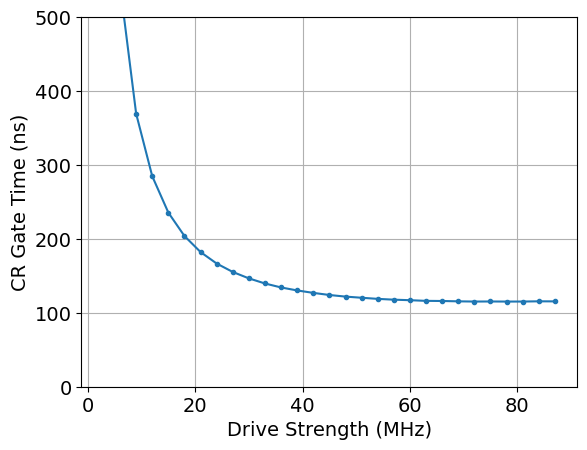

In [18]:
plt.plot(E_list,ts,'.-')
plt.grid()
plt.xlabel("Drive Strength (MHz)")
plt.ylabel(r"CR Gate Time (ns)")
plt.ylim(0,500)
plt.show()

In [19]:
# Save the list of times
CR_times_path = "./pickles/cr_pulse_times_example.pkl"

# Create a dictionary of dict[E_list[i]] = ts[i]
# This is the standard format for saving pulse times
tdict = dict(zip(E_list, ts))

# Save
with open(CR_times_path,'wb') as f:
    pickle.dump(tdict,f)

### Error Budget

In [20]:
calib_path = CR_times_path
# no_CP = False # Use this to also get E_CP
E, E_T, E_C, E_specs, E_leak = pr.E_vs_F_new_error_budget(ctrl,tgt,drive_frequency, calib_path, pulse_function,args = args)

100%|██████████| 29/29 [00:04<00:00,  5.82it/s]


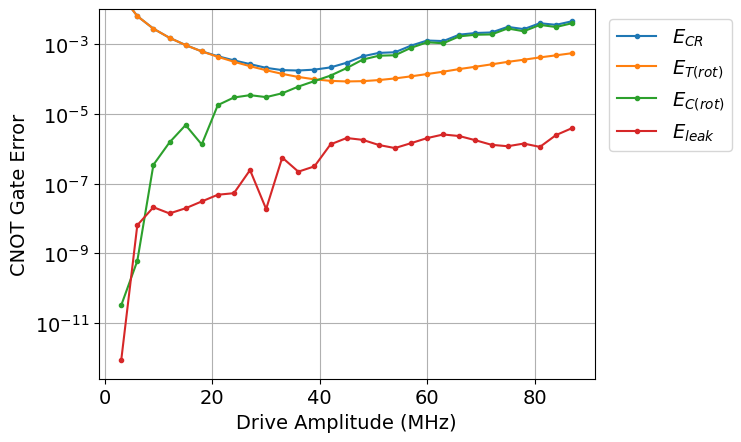

In [21]:
plt.semilogy(E_list,np.array(E), '.-', label = r'$E_{{CR}}$')
# plt.semilogy(E_list,np.array(E_CP), '.-', label = r'$E_{{CP}}$')
plt.semilogy(E_list,np.array(E_T), '.-', label = r'$E_{{T (rot)}}$')
plt.semilogy(E_list,np.array(E_C), '.-', label = r'$E_{{C (rot)}}$')
plt.semilogy(E_list,np.array(E_leak), '.-', label = r'$E_{{leak}}$')

plt.grid()
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("CNOT Gate Error", fontsize = 14)
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.0), fontsize = 14)
plt.show()

## Bloch Sphere Visualization

In [22]:
# Use the cosine rise/fall function already written in the library
# If need be, you can define your own pulse function, and pass arguments using a dictionary, as shown below
pulse_function = pulse_coeff

# Configure Pulse Parameters
args = {}
# Max pulse amplitude in Grad/s
args['Emax'] = 1e-3*39*2*np.pi
# Pulse time in ns
args['tp'] = 140
# Fraction of total pulse time occupied by rise time
args['rf'] = 0.3
# Discretization of the pulse
args['t_step'] = 0.5

# List of time points
t_list = np.arange(0,args['tp'],args['t_step'])

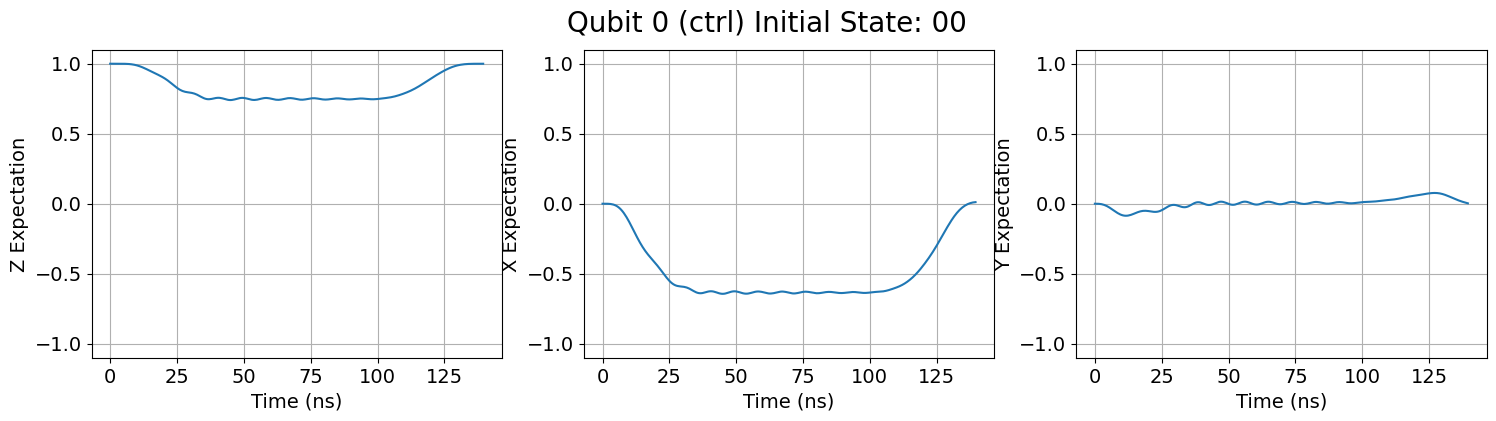

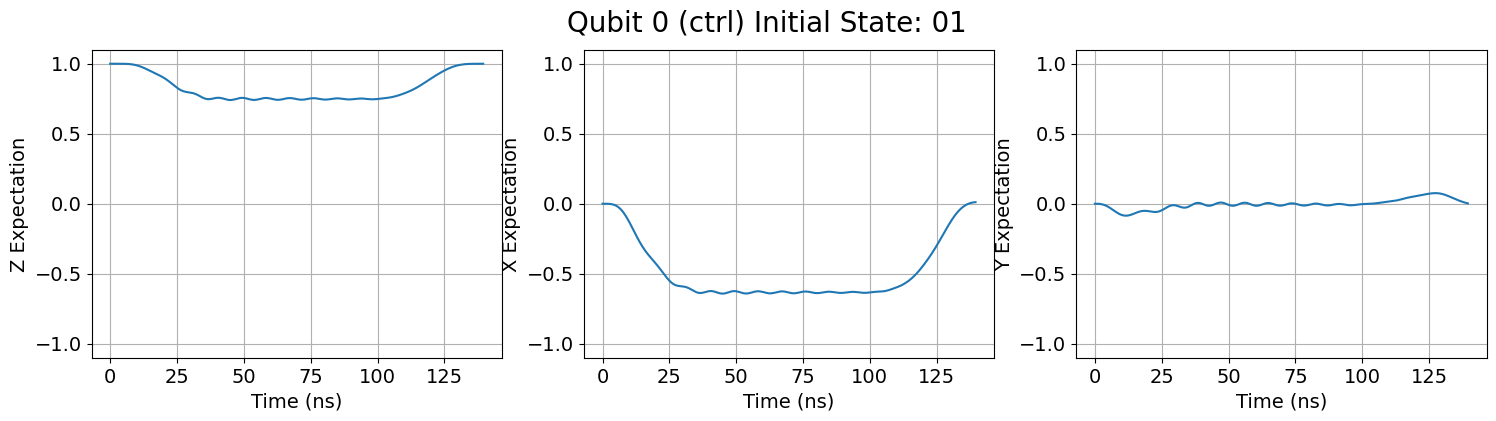

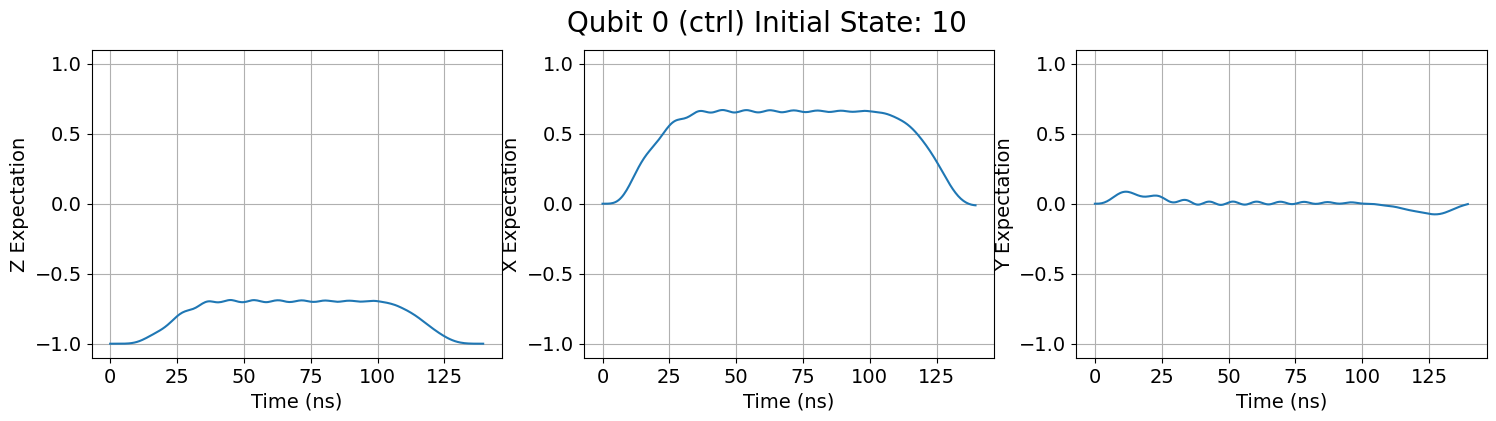

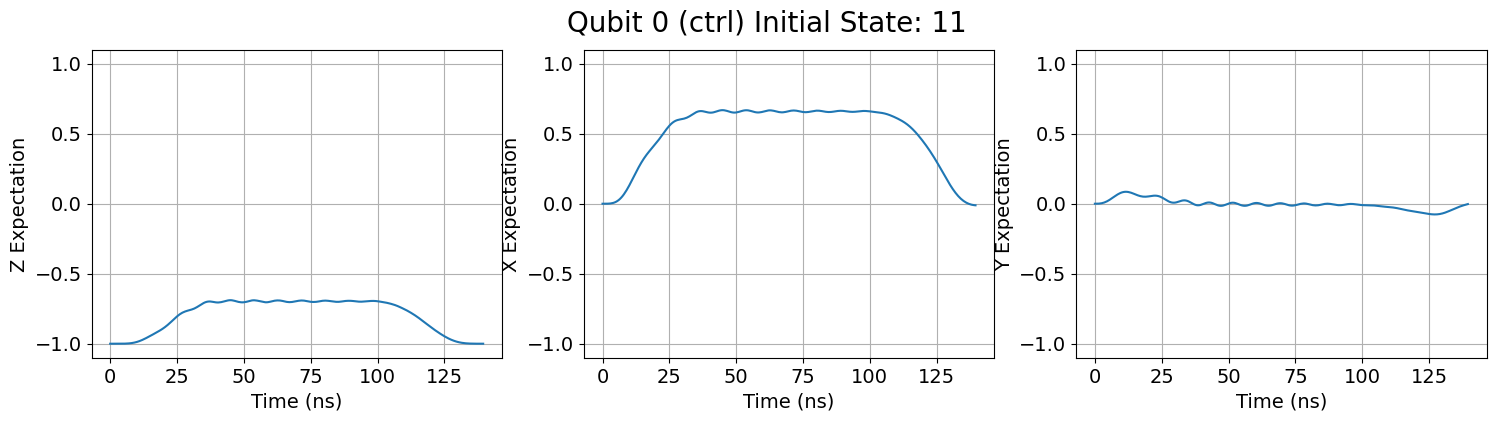

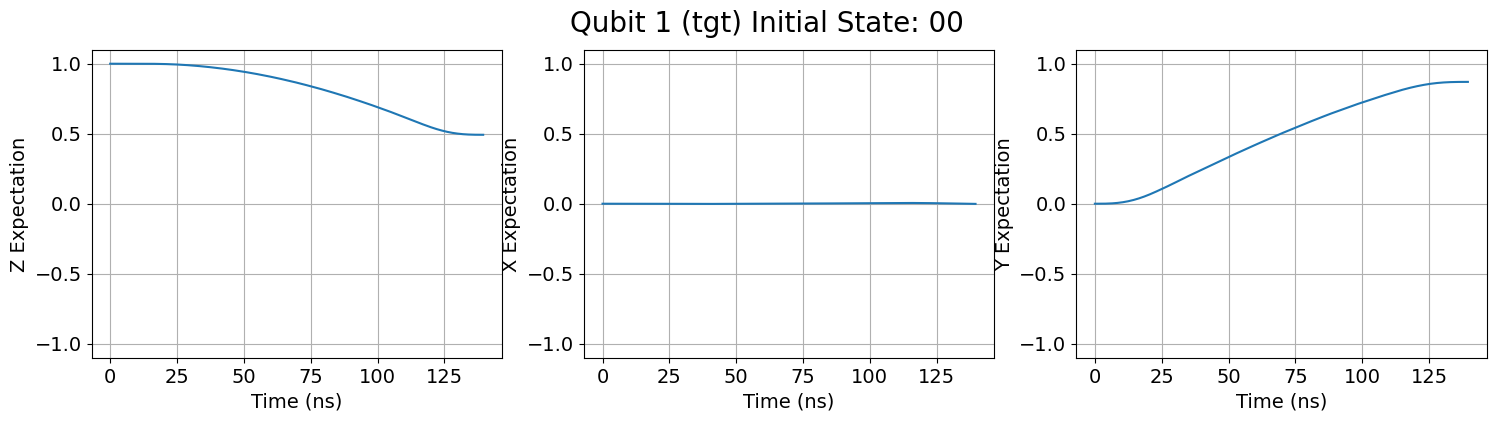

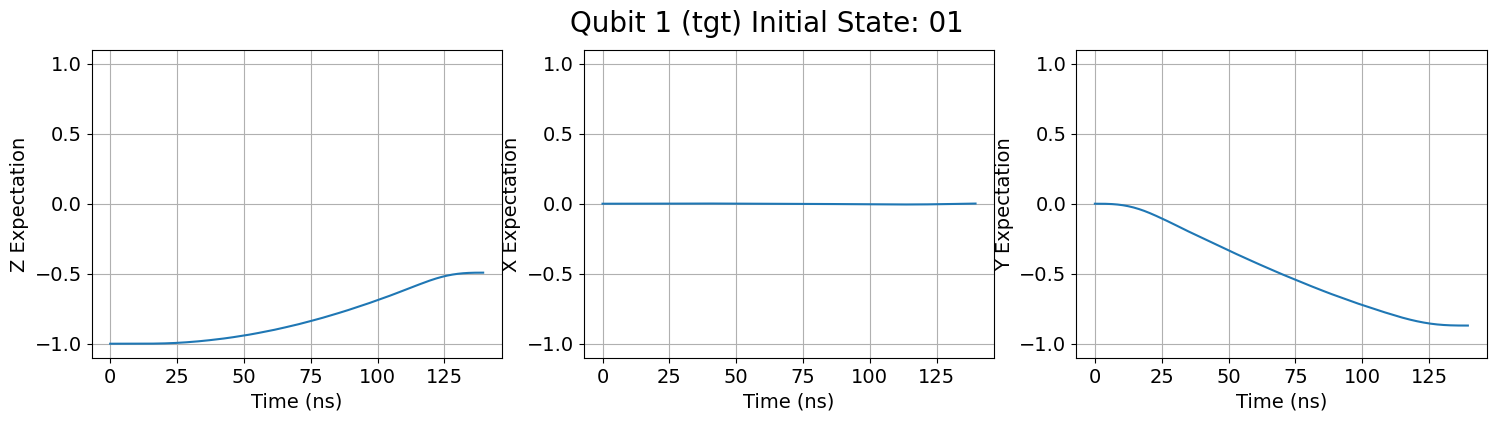

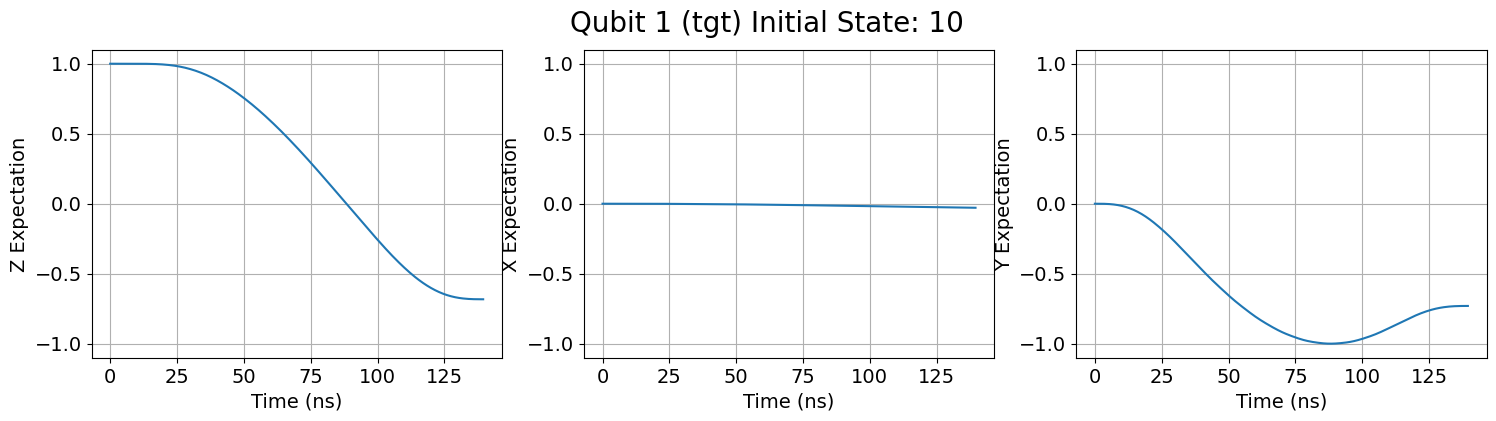

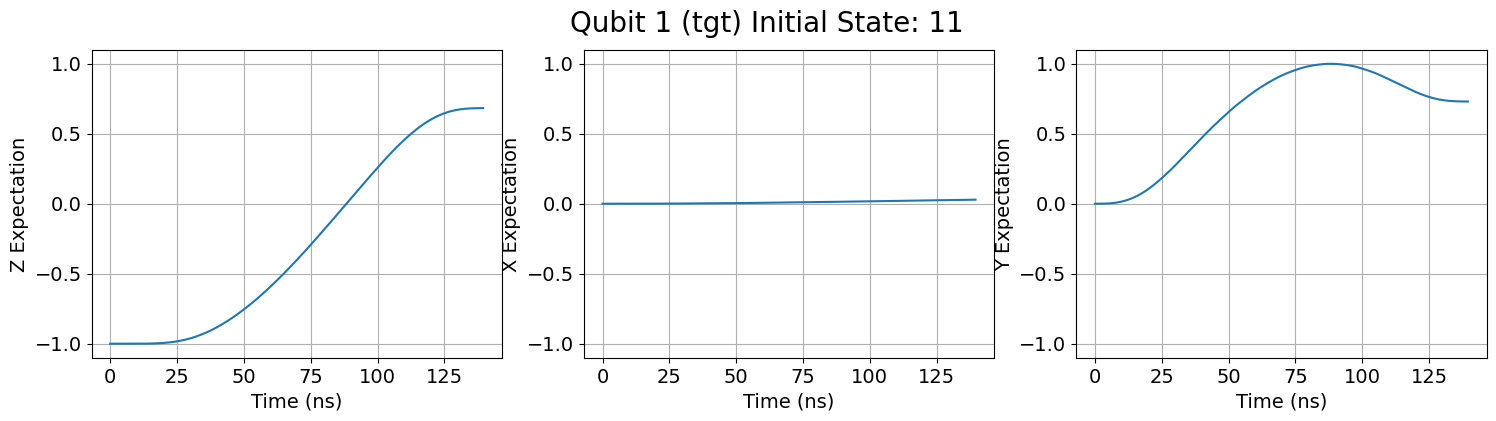

In [23]:
# Plot expectation values
pr.plot_expectation_values(ctrl,tgt,drive_frequency,pulse_function,t_list,args)

In [24]:
bloch_sphere_path = './Bloch_sphere_animations/'
animate_time_step = 10
# Currently the animate = True is not working on my MacBook, it worked perfectly in my laptop. 
# The code is the same. Some debugging/upgradation required
pr.Bloch_sphere_visualize(bloch_sphere_path,animate_time_step,0,1,drive_frequency,pulse_function,t_list,args,animate = False,use_points=False)

state:  00  qubit:  0
state:  01  qubit:  0
state:  10  qubit:  0
state:  11  qubit:  0
state:  00  qubit:  1
state:  01  qubit:  1
state:  10  qubit:  1
state:  11  qubit:  1


# 3 Qubits

## Configuration


In [30]:
# Configure Processor
# Number of Qubits
N = 3

# Number of Levels per qubit
N_l = 4

# Frequencies of qubits, in Grad/s
w = np.array([5.19,5.3,5.23])*2*np.pi

# Anharmonicities of qubits in Grad/s
anh_array = np.array([0.3,0.3,0.3])*2*np.pi

# Coupling between qubits in Grad/s
J = np.array([[0,3,0],
              [3,0,3],
              [0,3,0]])*1e-3*2*np.pi

# Specification of which qubit is control and which is target
control_target = [[0,0,0],
                  [1,0,1],
                  [0,0,0]]

# Note: Other variables to enable progress bars/saving of propagators can be enabled.
# Look at the __init__ function of the processor class

In [31]:
# Define the main class object
pr = processor(N,N_l,w,anh_array,J,control_target)

In [32]:
# Use the cosine rise/fall function already written in the library
# If need be, you can define your own pulse function, and pass arguments using a dictionary, as shown below
pulse_function = pulse_coeff

# Configure Pulse Parameters
args = {}
# Max pulse amplitude in Grad/s
args['Emax'] = 1e-3*39*2*np.pi
# Pulse time in ns
args['tp'] = 140
# Fraction of total pulse time occupied by rise time
args['rf'] = 0.3
# Discretization of the pulse
args['t_step'] = 0.5

# List of time points
t_list = np.arange(0,args['tp'],args['t_step'])

### Processor Diagnostics

In [33]:
# Run processor diagnostics to check for proximity to poles
# See thesis page 14, 15, 16
# Set tolerance for proximity to poles, in this case 30 MHz
tol = 30*1e-3*2*np.pi
check_resonance(pr,tol)

# Prints a table of control target pairs
# And indicates which region of the frequency landscape their detuning lies
# See plots on thesis page 14
region_classifier(pr)

+----------+---+---+---+
| Ctrl\Tgt | 0 | 1 | 2 |
+----------+---+---+---+
| 0        | - | - | - |
+----------+---+---+---+
| 1        | 2 | - | 2 |
+----------+---+---+---+
| 2        | - | - | - |
+----------+---+---+---+


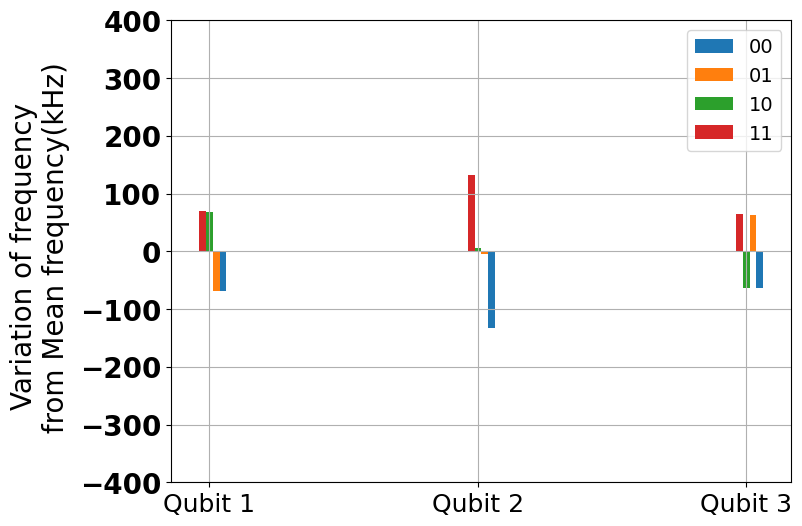

In [34]:
pr.plot_static_zz(option = 'Mean', legend = True)

## CR Gate

For the sake of brevity, single qubit gates are omitted

In [35]:
# Define the Control and Target
ctrl = 1
tgt = 2
# Use mean kerr frequency of target
drive_frequency = pr.qubits[tgt]['w_mean_kerr']

### Calibration

In [36]:
# List of drive strengths to calibrate for, in MHz
E_list = np.arange(3,90,3)
# Trial times to use for extrapolation and calibration (see thesis)
t_list = np.arange(50,150,25)
ts,phi0,phi1 = pr.calibrate_cnot_t(ctrl,tgt,drive_frequency,pulse_function,args, use_optimizer= True, use_zero_initial_values = False)

100%|██████████| 29/29 [01:12<00:00,  2.50s/it]


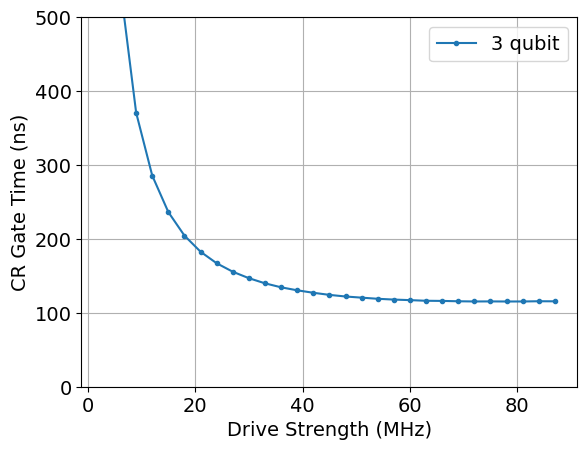

In [37]:
# Plot
plt.plot(E_list,ts,'.-', label = '3 qubit')
plt.grid()
plt.xlabel("Drive Strength (MHz)")
plt.ylabel(r"CR Gate Time (ns)")
plt.ylim(0,500)
plt.legend()
plt.show()

In [38]:
# Save the list of times
CR_times_3_qubit_path = "./pickles/cr_pulse_times_3_qubit_example.pkl"

# Create a dictionary of dict[E_list[i]] = ts[i]
# This is the standard format for saving pulse times
tdict = dict(zip(E_list, ts))

# Save
with open(CR_times_3_qubit_path,'wb') as f:
    pickle.dump(tdict,f)

### Error Budget

In [39]:
# Compute Error budget using calibrated times
calib_path = CR_times_3_qubit_path
# no_CP = False # Use this to also get E_CP, pass it as an argument to the below function
E, E_T, E_C, E_specs, E_leak = pr.E_vs_F_new_error_budget(ctrl,tgt,drive_frequency, calib_path, pulse_function,args = args)

100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


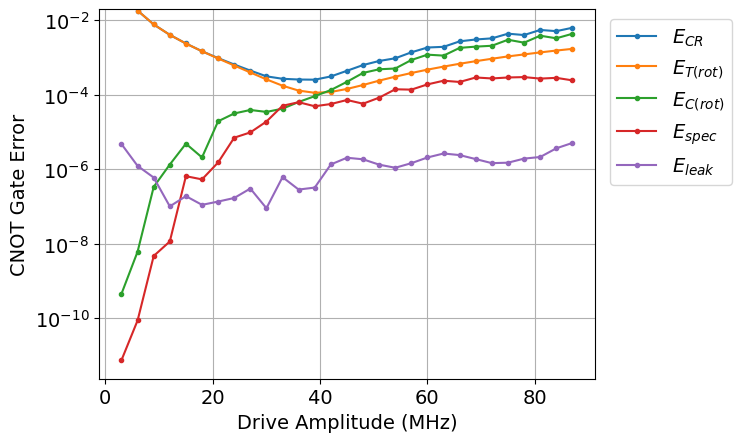

In [40]:
# Plot
plt.semilogy(E_list,np.array(E), '.-', label = r'$E_{{CR}}$')
# plt.semilogy(E_list,np.array(E_CP), '.-', label = r'$E_{{CP}}$')
plt.semilogy(E_list,np.array(E_T), '.-', label = r'$E_{{T (rot)}}$')
plt.semilogy(E_list,np.array(E_C), '.-', label = r'$E_{{C (rot)}}$')
plt.semilogy(E_list,np.array([i[0] for i in E_specs]), '.-', label = r'$E_{{spec}}$')
plt.semilogy(E_list,np.array(E_leak), '.-', label = r'$E_{{leak}}$')

plt.grid()
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("CNOT Gate Error", fontsize = 14)
plt.ylim(0,0.02)
plt.legend(bbox_to_anchor = (1.01,1.0), fontsize = 14)
plt.show()

### Spectator Frequency Sweep

In [41]:
# Configure args for spec sweep
# In this case, we have used the same pulse for every spectator frequency
# This is not ideal. In the next example, we have tested different drive strengths at each spectator frequency
args = {}

# For 70 MHz
args['Emax'] = 1e-3*36*2*np.pi
args['tp'] = 165.63
args['rf'] = 0.3
args['t_step'] = 0.5
t = np.arange(0,args['tp'],args['t_step'])

# Set spectator, control and target
spec = 0
ctrl = 1
tgt = 2

def return_f_spec_sweep_class(ws, spec = spec):
    # Function to paralellize the sweep
    # Frequency of the spectator
    w[spec] = ws
    try:
        # Define the processor
        pr = processor(N,N_l,w,anh_array,J,control_target)
        # Set the drive frequency
        drive_frequency = pr.qubits[tgt]['w_mean_kerr']
        # Extract the propagator
        M = pr.get_M(ctrl,tgt,drive_frequency,pulse_function,t,args)        
        # Extract the error budget from the propagator
        E, E_CP, E_T, E_C, E_specs, E_leak = pr.get_new_error_budget(M, no_CP = False)
        return E, E_CP, E_T, E_C, E_specs, E_leak
    except:
        # In case one of the points goes wrong, return 0
        print("Error ", sys.exc_info()[0], "occured")
        return 0

# Define the range of frequencies
# Some frequencies are intentionally left out. 
# For example, f = 5.3 GHz is a point of degeneracy, so it is skipped
# This is because it might cause errors when diagonalizing the hamiltonian
f_range_1 = list(np.arange(5.03,5.298,0.002))
f_range_2 = list(np.arange(5.302,5.57,0.002))
f_range = np.array(f_range_1+f_range_2)
ws_range = 2*np.pi*f_range

In [42]:
# Paralellalize the sweep
# n_jobs = -1 will use all available CPU cores, this is fastest
# This might slow your system down a little
# So you can use n_jobs = -2, which leaves some threads free
E_spec_sweep_class_3_error_budget = Parallel(n_jobs=-1)(delayed(return_f_spec_sweep_class)(w) for w in tqdm(ws_range))

100%|██████████| 269/269 [00:19<00:00, 13.50it/s]


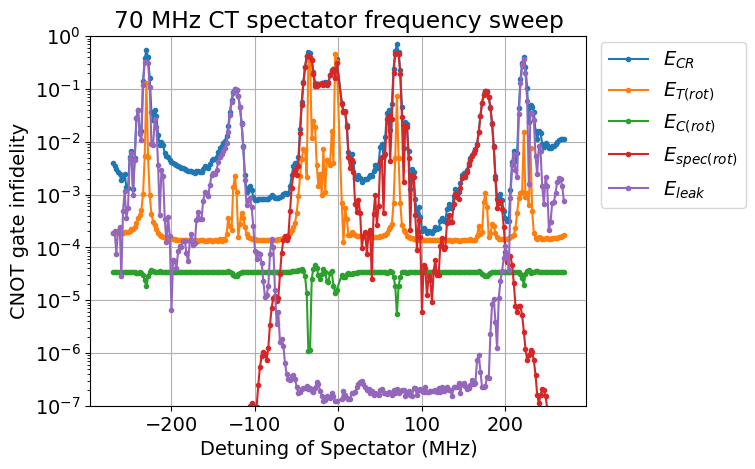

In [43]:
# Plot all errors
plt.semilogy(1e3*(5.3 - f_range),np.array([i[0] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{CR}$")
# plt.semilogy(1e3*(5.3 - f_range),np.array([i[1] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{CP}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[2] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{T (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[3] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{C (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[4][0] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{spec (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[5] for i in E_spec_sweep_class_3_error_budget]),'.-', label = r"$E_{leak}$")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.ylim(1e-7,1)
plt.grid()
plt.title("70 MHz CT spectator frequency sweep")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

### Spectator Frequency Sweep best E vs F Point

In [44]:
# Configure args for spec sweep
# In this example, for each spectator frequency, the best drive strength is found
# This is the drive strength with the greatest gate fidelity
# So a sweep of drives strength vs fidelity is done (E vs F)
# And the best point is extracted

# Initial pulse configuration
# Emax, tp will be changed in each subsequent iteration
args = {}
args['Emax'] = 1e-3*36*2*np.pi
args['tp'] = 139.64
args['rf'] = 0.3
args['t_step'] = 0.5
t = np.arange(0,args['tp'],args['t_step'])

# Set control and target and spectator
spec = 0
ctrl = 1
tgt = 2

# These values are the values within which the sweep over E is done
# This is imposed to save time
# However, the values of E for which you have previously calibrated will be used
# depending on the calib_path that your provide

E_max = 60
E_min = 12

def return_f_spec_sweep_class(ws, spec = spec):
    # Set spectator frequency
    # Change this index if 
    w[spec] = ws
    try:
        # Define the new processor
        pr = processor(N,N_l,w,anh_array,J,control_target)
        # Set drive frequency
        drive_frequency = pr.qubits[tgt]['w_mean_kerr']
        # Extract E vs F
        E, E_CP, E_T, E_C, E_specs, E_leak = pr.E_vs_F_new_error_budget(ctrl,tgt,drive_frequency, 
                                                                        calib_path, pulse_function, args, use_optimizer = True, 
                                                                        use_zero_initial_values = False, 
                                                                        E_max = E_max, E_min = E_min, 
                                                                        no_progress_bar=True, no_CP = False)
        # Find the index for the least error
        ind = np.argmin(E)
        # Return the appropriate points
        return E[ind], E_CP[ind], E_T[ind], E_C[ind], E_specs[ind], E_leak[ind],ind
    except:
        print("Error ", sys.exc_info()[0], "occured")
        return 0

In [45]:
# Configure Processor
N = 3
N_l = 4
spec = 0
ctrl = 1
tgt = 2
f_range = np.arange(5.03,5.57,0.002)
ws_range = 2*np.pi*f_range

In [46]:
E_spec_sweep_class_3_error_budget_best_E = Parallel(n_jobs=-1)(delayed(return_f_spec_sweep_class)(w) for w in tqdm(ws_range))

100%|██████████| 270/270 [03:12<00:00,  1.40it/s]


In [80]:
# Save results
save_path = "./pickles/3_qubit_spectator_sweep_broader_range_70_MHz_CT_spec_control_coupling_best_E_vs_F_point.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(E_spec_sweep_class_3_error_budget_best_E,f)

In [94]:
# Load old results
load_path = "./pickles/CR_gate_raw_fidelity/class_results/3_qubit_spectator_sweep_broader_range_70_MHz_CT_spec_control_coupling_best_E_vs_F_point.pkl"
with open(load_path, 'rb') as f:
    E_spec_sweep_class_3_error_budget_best_E = pickle.load(f)

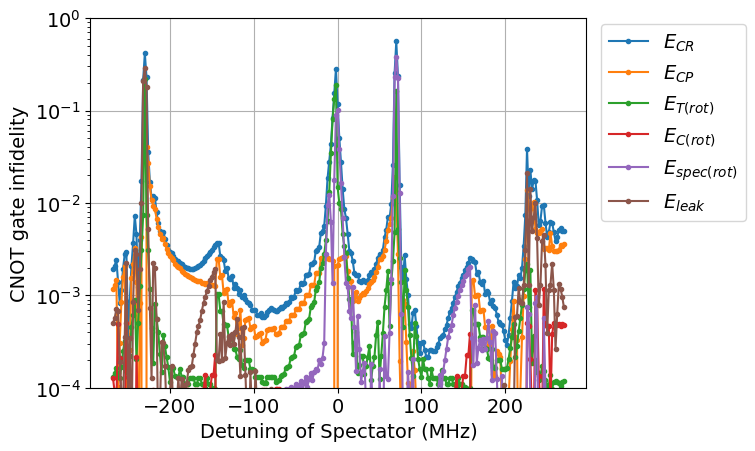

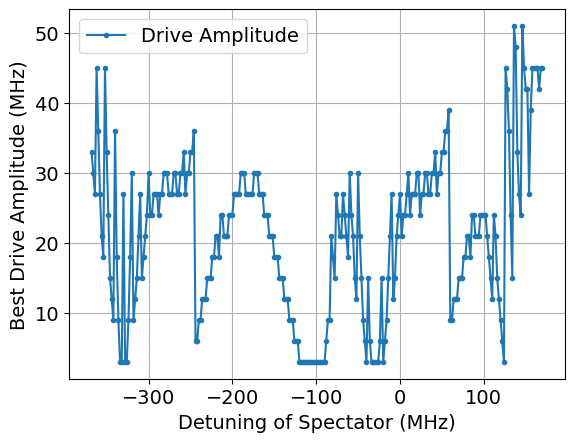

In [47]:
# Plot all results
plt.semilogy(1e3*(5.3 - f_range),np.array([i[0] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{CR}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[1] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{CP}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[2] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{T (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[3] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{C (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[4][0] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{spec (rot)}$")
plt.semilogy(1e3*(5.3 - f_range),np.array([i[5] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{leak}$")

plt.legend(bbox_to_anchor = (1.01,1.01))
plt.ylim(1e-4,1)
plt.grid()
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

# Plot the best drive strength
plt.plot(1e3*(5.2 - f_range),np.array([E_list[i[-1]] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = 'Drive Amplitude') 
plt.grid()
plt.legend()
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("Best Drive Amplitude (MHz)")
plt.show()


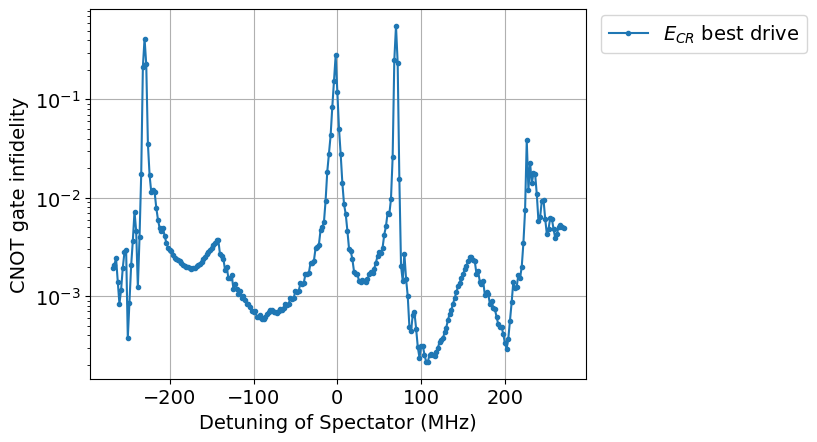

In [48]:
# Plot only best fidelity
plt.semilogy(1e3*(5.3 - f_range),np.array([i[0] for i in E_spec_sweep_class_3_error_budget_best_E]),'.-', label = r"$E_{CR}$" +' best drive')
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.grid()
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()